In [13]:
import os
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm
import soundfile as sf
import matplotlib.pyplot as plt
from hebrew import Hebrew
from hebrew.chars import HebrewChar, ALEPH
from hebrew import GematriaTypes
import sys
from typing import Tuple
import pandas as pd
from HebrewToEnglish import HebrewToEnglish
from pydub import AudioSegment
from typing import Tuple, List,Set
import pandas as pd
from typing import Tuple, List
import soundfile as sf
%matplotlib inline

In [14]:
def get_duration_in_seconds(audio_path: str) -> float:
    info = sf.info(audio_path)
    return info.frames / info.samplerate

def filter_and_clean_transcripts(metadata: pd.DataFrame, audio_base_path: str) -> Tuple[pd.DataFrame, List[str]]:
    """
    Filters out rows with:
    - transcripts that have fewer than 2 words
    - audio files longer than 20 seconds
    
    Strips whitespace and returns cleaned DataFrame + list of filtered file_ids.
    """
    raw_transcript = metadata[["file_id", "transcript_in_english"]].copy()
    raw_transcript["transcript_in_english"] = raw_transcript["transcript_in_english"].astype(str).str.rstrip()

    # Filter by word count
    word_counts = raw_transcript["transcript_in_english"].str.split().apply(len)
    too_few_words_mask = word_counts < 2

    # Filter by duration
    durations = raw_transcript["file_id"].apply(lambda fid: get_duration_in_seconds(f"{audio_base_path}/{fid}.wav"))
    too_long_audio_mask = durations > 30

    # Combine both masks
    bad_mask = too_few_words_mask | too_long_audio_mask

    # File IDs to remove
    notgood = raw_transcript.loc[bad_mask, "file_id"].tolist()
    
    print(f"Filtered out {len(notgood)} entries with too few words or too long audio.")
    print(f"Total entries before filtering: {len(raw_transcript)}")
    print(f"Total entries after filtering: {len(raw_transcript) - len(notgood)}")

    # Keep only good entries
    raw_transcript = raw_transcript.loc[~bad_mask].reset_index(drop=True)

    return raw_transcript, notgood



In [15]:
def get_dataset_config(
    set_type: str,
    base_paths: dict
) -> Tuple[pd.DataFrame, str, str, str]:
    """
    Returns metadata, output filename, input path and output path for given set type.

    Args:
        set_type (str): One of 'train', 'dev'
        base_paths (dict): A dictionary with keys 'train' and 'dev', each containing paths:
                           'metadata_path', 'input_path', 'output_path', 'file_name_output'

    Returns:
        metadata (pd.DataFrame): The metadata dataframe
        file_name_output (str): Name of the output text file
        input_path (str): Path to input .wav files
        output_path (str): Path to save processed .wav files
    """
    if set_type not in base_paths:
        raise ValueError(f"Unsupported set_type '{set_type}'. Choose from {list(base_paths.keys())}.")

    cfg = base_paths[set_type]
    metadata = pd.read_csv(cfg["metadata_path"], delimiter='|')
    return metadata, cfg["file_name_output"], cfg["input_path"], cfg["output_path"]

In [16]:
def plot_duration_histogram_from_filelist(filelist_path: str, bins: int = 50):
    durations = []

    try:
        with open(filelist_path, 'r', encoding='utf-8') as f:
            for line in f:
                if '|' in line:
                    wav_path = line.strip().split('|')[0]
                    if wav_path.endswith(".wav"):
                        try:
                            duration = get_duration_in_seconds(wav_path)
                            durations.append(duration)
                        except Exception as e:
                            print(f"Error reading {wav_path}: {e}")
    except FileNotFoundError:
        print(f"File not found: {filelist_path}")
        return

    if not durations:
        print("No valid .wav files found or all files failed to load.")
        return

    # Plotting
    plt.hist(durations, bins=bins, edgecolor='black')
    plt.title("Histogram of Audio File Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of Files")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Processing training dataset...
File list: /gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/filelists/train_list15.txt


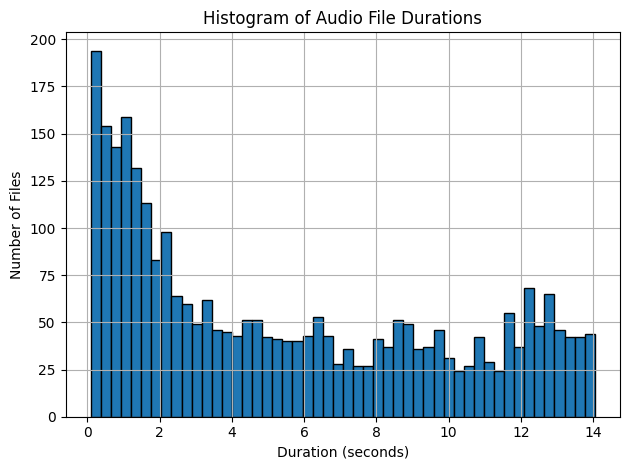

Processing dev dataset...
File list: /gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/filelists/dev_list15.txt


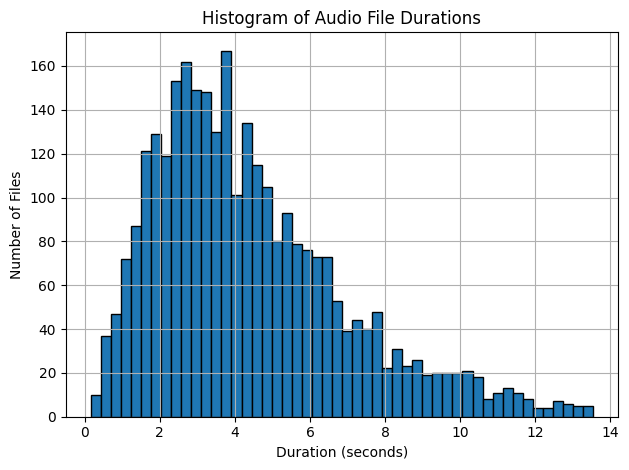

In [17]:

# Example usage:

paths = {
    "train": {
        "metadata_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_automatic_data/metadata.csv",
        "input_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_automatic_data/wavs/",
        "output_path": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/tacotron2/data/saspeech_automatic_data/wavs/",
        "file_name_output": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/filelists/train_list15.txt"
    },
    "dev": {
        "metadata_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_gold_standard/metadata_full.csv",
        "input_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_gold_standard/wavs/",
        "output_path": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/tacotron2/data/saspeech_gold_standard/wavs/",
        "file_name_output": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/filelists/dev_list15.txt"
    }
}

# === Load train ===
metadata, file_name_output, input_path, output_path = get_dataset_config('train', paths)
print("Processing training dataset...")
print(f"File list: {file_name_output}")
plot_duration_histogram_from_filelist(file_name_output)

# === Load dev ===
metadata, file_name_output, input_path, output_path = get_dataset_config('dev', paths)
print("Processing dev dataset...")
print(f"File list: {file_name_output}")
plot_duration_histogram_from_filelist(file_name_output)
